In [1]:
#import library

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
import itertools
import seaborn as sns
from pandas.tseries.holiday import USFederalHolidayCalendar

import warnings
warnings.filterwarnings("ignore")

Load datasets

In [2]:
# Load datasets
pizza_sales = pd.read_csv("Pizza_Sale.csv")
pizza_ingredients = pd.read_csv("Pizza_ingredients.csv")

Clean and preprocess the data

In [3]:
# Clean and preprocess the data
pizza_sales[['pizza_name_id', 'pizza_category', 'pizza_ingredients', 'pizza_name']] = pizza_sales[['pizza_name_id', 'pizza_category', 'pizza_ingredients', 'pizza_name']].ffill()

pizza_sales['total_price'] = pizza_sales['total_price'].interpolate(method='linear')

In [4]:
# standardize datatype

pizza_sales['order_date'] = pd.to_datetime(pizza_sales['order_date'], format='%d-%m-%Y', errors='coerce')
pizza_sales = pizza_sales[pizza_sales['order_date'].notna()]

In [5]:
# Outlier: Z-score method/trimming delete outlier
upper_limit = pizza_sales['total_price'].mean() + 3 * pizza_sales['total_price'].std()
lower_limit = pizza_sales['total_price'].mean() - 3 * pizza_sales['total_price'].std()
pizza_sales = pizza_sales[(pizza_sales['total_price'] <= upper_limit) & (pizza_sales['total_price'] >= lower_limit)]



In [6]:
pizza_ingredients.isna().sum()

pizza_name_id         0
pizza_name            0
pizza_ingredients     0
Items_Qty_In_Grams    4
dtype: int64

In [7]:
#missing values fill with mean
pizza_ingredients['Items_Qty_In_Grams'] = pizza_ingredients.groupby('pizza_name_id')['Items_Qty_In_Grams'].ffill()


In [8]:
pizza_ingredients.isna().sum()

pizza_name_id         0
pizza_name            0
pizza_ingredients     0
Items_Qty_In_Grams    3
dtype: int64

In [9]:
# Group by 'order_date' to get daily sales
daily_sales = pizza_sales.groupby('order_date')['total_price'].sum().reset_index()
daily_sales.rename(columns={'total_price': 'daily_sales'}, inplace=True)

Feature Engineering

In [10]:
# Feature Engineering: Adding holidays
calendar = USFederalHolidayCalendar()
holidays_list = calendar.holidays(start=daily_sales['order_date'].min(), end=daily_sales['order_date'].max())
daily_sales['is_holiday'] = daily_sales['order_date'].isin(holidays_list).astype(int)



In [11]:

# Lag Features: Adding lag 1 and lag 7 features
daily_sales['lag_1'] = daily_sales['daily_sales'].shift(1)
daily_sales['lag_7'] = daily_sales['daily_sales'].shift(7)

# Drop missing values from lag columns
daily_sales.dropna(inplace=True)


Exploratory Data Analysis (EDA)

Sales Trends Analysis

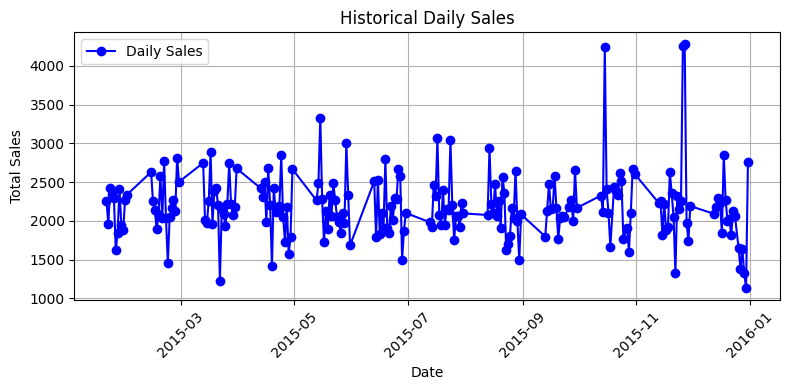

In [12]:
#EDA

import pandas as pd
import matplotlib.pyplot as plt

# Plot historical daily sales data
plt.figure(figsize=(8, 4))
plt.plot(pd.to_datetime(daily_sales['order_date']), daily_sales['daily_sales'], marker='o', color='b', linestyle='-', label='Daily Sales')
plt.title('Historical Daily Sales')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


Rolling Averages

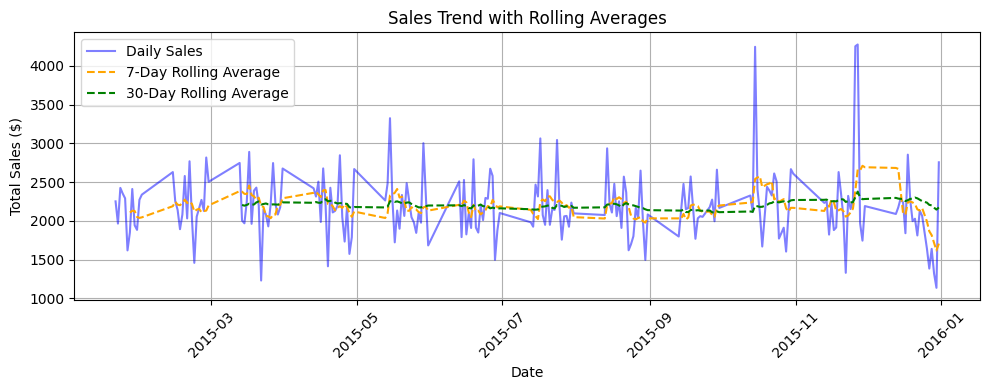

In [13]:
daily_sales_7day = daily_sales['daily_sales'].rolling(window=7).mean()
daily_sales_30day = daily_sales['daily_sales'].rolling(window=30).mean()

plt.figure(figsize=(10, 4))
plt.plot(pd.to_datetime(daily_sales['order_date']), daily_sales['daily_sales'], label='Daily Sales', color='blue', alpha=0.5)
plt.plot(pd.to_datetime(daily_sales['order_date']), daily_sales_7day, label='7-Day Rolling Average', color='orange', linestyle='--')
plt.plot(pd.to_datetime(daily_sales['order_date']), daily_sales_30day, label='30-Day Rolling Average', color='green', linestyle='--')
plt.title('Sales Trend with Rolling Averages')
plt.xlabel('Date')
plt.ylabel('Total Sales ($)')
plt.legend()
plt.xticks(rotation=45) 
plt.grid(True)
plt.tight_layout()
plt.show()


Seasonality and Patterns

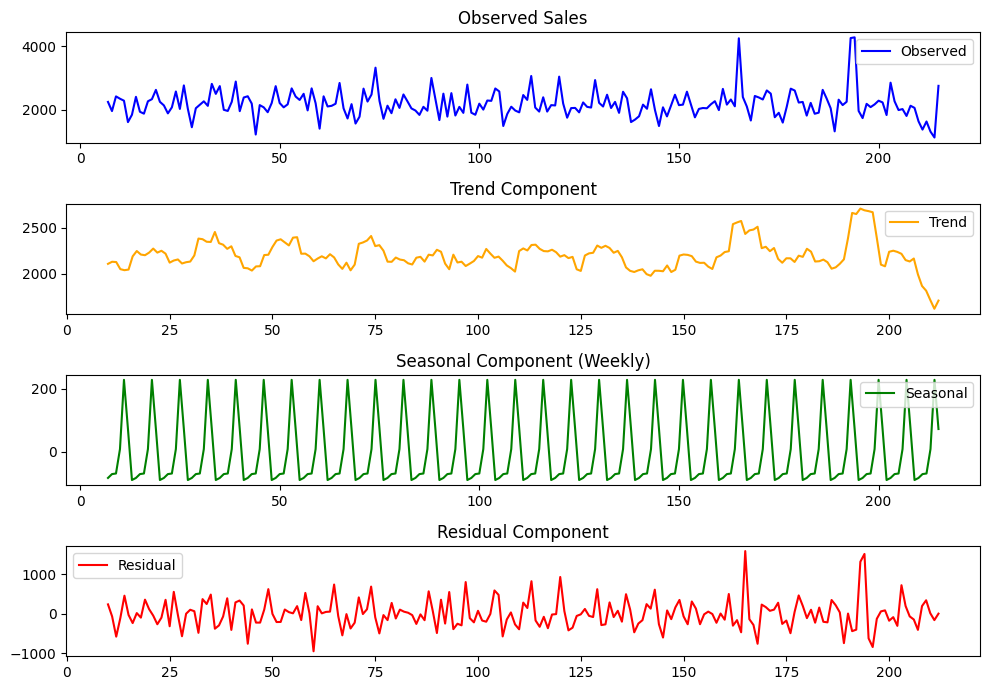

In [14]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(daily_sales['daily_sales'], model='additive', period=7)

plt.figure(figsize=(10, 7))
plt.subplot(411)
plt.plot(decomposition.observed, label='Observed', color='blue')
plt.title('Observed Sales')
plt.legend()

plt.subplot(412)
plt.plot(decomposition.trend, label='Trend', color='orange')
plt.title('Trend Component')
plt.legend()

plt.subplot(413)
plt.plot(decomposition.seasonal, label='Seasonal', color='green')
plt.title('Seasonal Component (Weekly)')
plt.legend()

plt.subplot(414)
plt.plot(decomposition.resid, label='Residual', color='red')
plt.title('Residual Component')
plt.legend()

plt.tight_layout()
plt.show()


Identifying Patterns in Features

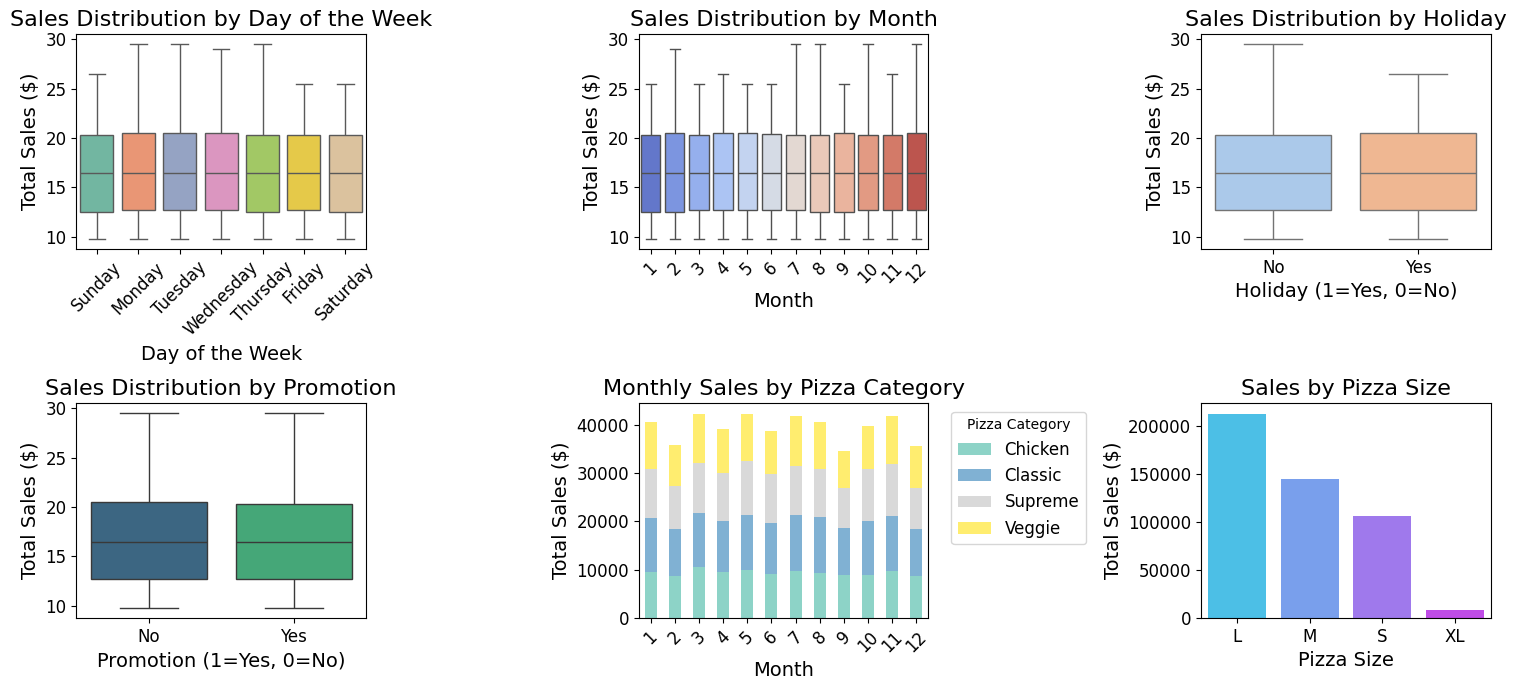

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.tseries.holiday import USFederalHolidayCalendar

pizza_sales['order_date'] = pd.to_datetime(pizza_sales['order_date'])

pizza_sales_with_holiday = pizza_sales.copy()

calendar = USFederalHolidayCalendar()
holidays_list = calendar.holidays(start=pizza_sales['order_date'].min(), end=pizza_sales['order_date'].max())
pizza_sales_with_holiday['is_holiday'] = pizza_sales_with_holiday['order_date'].isin(holidays_list).astype(int)
pizza_sales_with_holiday['month'] = pizza_sales_with_holiday['order_date'].dt.month
pizza_sales_with_holiday['promotion_flag'] = pizza_sales_with_holiday['month'].apply(lambda x: 1 if x == 7 else 0)

fig, axes = plt.subplots(2, 3, figsize=(20, 14)) 
day_order = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
sns.boxplot(x=pizza_sales_with_holiday['order_date'].dt.day_name(), y='total_price', data=pizza_sales_with_holiday, palette='Set2', ax=axes[0, 0], order=day_order)
axes[0, 0].set_title('Sales Distribution by Day of the Week', fontsize=16)
axes[0, 0].set_xlabel('Day of the Week', fontsize=14)
axes[0, 0].set_ylabel('Total Sales ($)', fontsize=14)
axes[0, 0].tick_params(axis='x', rotation=45, labelsize=12)
axes[0, 0].tick_params(axis='y', labelsize=12)

# Sales Distribution by Month
pizza_sales_with_holiday['month'] = pd.Categorical(pizza_sales_with_holiday['month'], categories=range(1, 13), ordered=True)
sns.boxplot(x='month', y='total_price', data=pizza_sales_with_holiday, palette='coolwarm', ax=axes[0, 1])
axes[0, 1].set_title('Sales Distribution by Month', fontsize=16)
axes[0, 1].set_xlabel('Month', fontsize=14)
axes[0, 1].set_ylabel('Total Sales ($)', fontsize=14)
axes[0, 1].tick_params(axis='x', rotation=45, labelsize=12)
axes[0, 1].tick_params(axis='y', labelsize=12)

#Sales Distribution by Holiday
sns.boxplot(x='is_holiday', y='total_price', data=pizza_sales_with_holiday, palette='pastel', ax=axes[0, 2])
axes[0, 2].set_title('Sales Distribution by Holiday', fontsize=16)
axes[0, 2].set_xlabel('Holiday (1=Yes, 0=No)', fontsize=14)
axes[0, 2].set_ylabel('Total Sales ($)', fontsize=14)
axes[0, 2].set_xticklabels(['No', 'Yes'], fontsize=12)
axes[0, 2].tick_params(axis='y', labelsize=12)

#Sales Distribution by Promotion
sns.boxplot(x='promotion_flag', y='total_price', data=pizza_sales_with_holiday, palette='viridis', ax=axes[1, 0])
axes[1, 0].set_title('Sales Distribution by Promotion', fontsize=16)
axes[1, 0].set_xlabel('Promotion (1=Yes, 0=No)', fontsize=14)
axes[1, 0].set_ylabel('Total Sales ($)', fontsize=14)
axes[1, 0].set_xticklabels(['No', 'Yes'], fontsize=12)
axes[1, 0].tick_params(axis='y', labelsize=12)

#monthly sales by pizza category
sales_by_month_category = pizza_sales_with_holiday.groupby(['month', 'pizza_category']).agg({'total_price': 'sum'}).reset_index()
sales_by_month_category_pivot = sales_by_month_category.pivot_table(index='month', columns='pizza_category', values='total_price', aggfunc='sum')


sales_by_month_category_pivot.plot(kind='bar', stacked=True, ax=axes[1, 1], colormap='Set3', figsize=(15, 7)) 
axes[1, 1].set_title('Monthly Sales by Pizza Category', fontsize=16)
axes[1, 1].set_xlabel('Month', fontsize=14)
axes[1, 1].set_ylabel('Total Sales ($)', fontsize=14)
axes[1, 1].tick_params(axis='x', rotation=45, labelsize=12)
axes[1, 1].tick_params(axis='y', labelsize=12)

axes[1, 1].legend(title='Pizza Category', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)

# Sales by Pizza Size
size_sales = pizza_sales_with_holiday.groupby('pizza_size').agg({'total_price': 'sum'}).reset_index()
size_sales = size_sales.sort_values('total_price', ascending=False) 

#Sales by Pizza Size
sns.barplot(x='pizza_size', y='total_price', data=size_sales, palette='cool', ax=axes[1, 2])
axes[1, 2].set_title('Sales by Pizza Size', fontsize=16)
axes[1, 2].set_xlabel('Pizza Size', fontsize=14)
axes[1, 2].set_ylabel('Total Sales ($)', fontsize=14)
axes[1, 2].tick_params(axis='x', labelsize=12)
axes[1, 2].tick_params(axis='y', labelsize=12)

plt.tight_layout()
plt.show()


ARIMA Model

Testing stationarity of original series:
ADF Statistic: -7.9094
p-value: 0.0000
The series is stationary.
Best ARIMA Order: (1, 0, 3)
Best MAPE: 19.2229

Day-by-Day Forecasted Sales for the Next Week:
          Date  Forecasted Sales
167 2016-01-01       2101.508831
168 2016-01-02       2084.768861
169 2016-01-03       2110.006723
170 2016-01-04       2117.709694
171 2016-01-05       2124.714557
172 2016-01-06       2131.084579
173 2016-01-07       2136.877294

Total Forecasted Sales for the Week: 14806.67


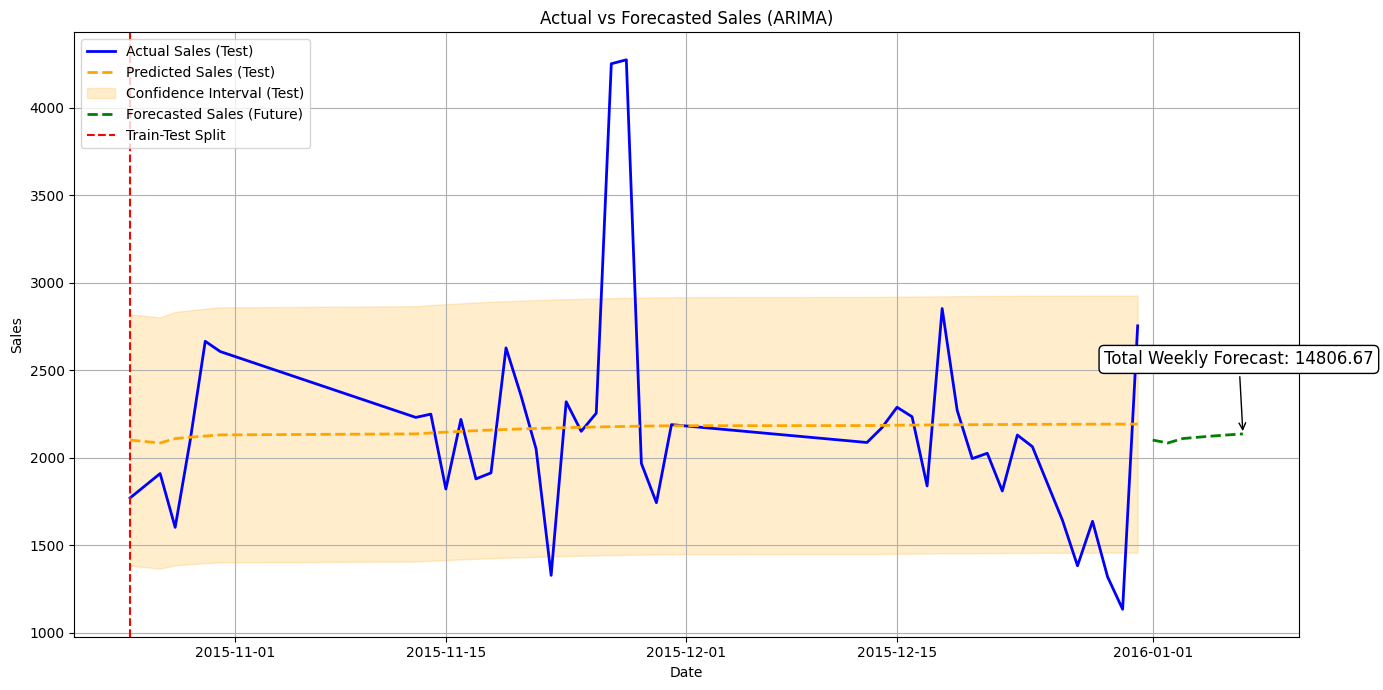

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
import itertools

def mape(actual, predicted):
   """Calculate Mean Absolute Percentage Error."""
   actual = np.where(actual == 0, 1e-6, actual)
   return np.mean(np.abs((actual - predicted) / actual)) * 100

def test_stationarity(series):
   """Perform Augmented Dickey-Fuller test on cleaned data."""
   series = series.dropna()
   if not np.isfinite(series).all():
       print("Series contains invalid values (NaN or inf). Please clean the data.")
       return
   result = adfuller(series)
   print(f"ADF Statistic: {result[0]:.4f}")
   print(f"p-value: {result[1]:.4f}")
   if result[1] > 0.05:
       print("The series is NOT stationary. Differencing is needed.")
   else:
       print("The series is stationary.")


print("Testing stationarity of original series:")
test_stationarity(daily_sales['daily_sales'])

# Split data into training and testing sets
train_size = int(len(daily_sales) * 0.8)
train, test = daily_sales[:train_size], daily_sales[train_size:]

# Grid search for ARIMA parameters
p_values, d_values, q_values = range(0, 5), range(0, 3), range(0, 5)
best_score = float("inf")
best_order = None
best_model = None

for p, d, q in itertools.product(p_values, d_values, q_values):
    try:
        model = ARIMA(train['daily_sales'], order=(p, d, q))
        model_fit = model.fit()
        predictions = model_fit.forecast(steps=len(test))
        error = mape(test['daily_sales'], predictions)
        if error < best_score:
            best_score = error
            best_order = (p, d, q)
            best_model = model_fit
    except Exception as e:
        continue

print(f"Best ARIMA Order: {best_order}")
print(f"Best MAPE: {best_score:.4f}")

# Forecasting future sales
forecast_steps = 7
forecast = best_model.forecast(steps=forecast_steps)
forecast_dates = pd.date_range(start=daily_sales['order_date'].iloc[-1] + pd.Timedelta(days=1), periods=forecast_steps)

forecast_df = pd.DataFrame({
    'Date': forecast_dates,
    'Forecasted Sales': forecast
})

total_forecasted_sales = forecast_df['Forecasted Sales'].sum()
print("\nDay-by-Day Forecasted Sales for the Next Week:")
print(forecast_df)
print(f"\nTotal Forecasted Sales for the Week: {total_forecasted_sales:.2f}")

plt.figure(figsize=(14, 7))
plt.plot(test['order_date'], test['daily_sales'], label='Actual Sales (Test)', color='blue', linestyle='-', linewidth=2)
predicted_sales = best_model.forecast(steps=len(test))
plt.plot(test['order_date'], predicted_sales, label='Predicted Sales (Test)', color='orange', linestyle='--', linewidth=2)

forecast_results = best_model.get_forecast(steps=len(test))
conf_int = forecast_results.conf_int()
plt.fill_between(test['order_date'], conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='orange', alpha=0.2, label='Confidence Interval (Test)')

plt.plot(forecast_df['Date'], forecast_df['Forecasted Sales'], label='Forecasted Sales (Future)', color='green', linestyle='--', linewidth=2)
plt.annotate(
    f"Total Weekly Forecast: {total_forecasted_sales:.2f}",
    xy=(forecast_df['Date'].iloc[-1], forecast_df['Forecasted Sales'].iloc[-1]),
    xytext=(-100, 50),
    textcoords='offset points',
    arrowprops=dict(facecolor='black', arrowstyle='->'),
    fontsize=12,
    bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white")
)

plt.axvline(x=test['order_date'].iloc[0], color='red', linestyle='--', label='Train-Test Split')

plt.title('Actual vs Forecasted Sales (ARIMA)')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend(loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


SARIMA Model

Testing stationarity of original series:
ADF Statistic: -7.909406451540381
p-value: 3.985243878539824e-12
Series is stationary (reject H0)
Best SARIMA Order: (0, 0, 0, 0, 0, 1)

Evaluation Metrics:
MAE: 474.4428
RMSE: 677.1540
MAPE: 3.6691
Day-by-Day Forecasted Sales for the Next Week:
    order_date  forecasted_sales
167 2016-01-01       1918.031251
168 2016-01-02       3120.370177
169 2016-01-03       1906.353899
170 2016-01-04       1784.389514
171 2016-01-05       1903.277848
172 2016-01-06       1529.477171
173 2016-01-07       1983.611774

Total Forecasted Sales for the Week: 14145.51


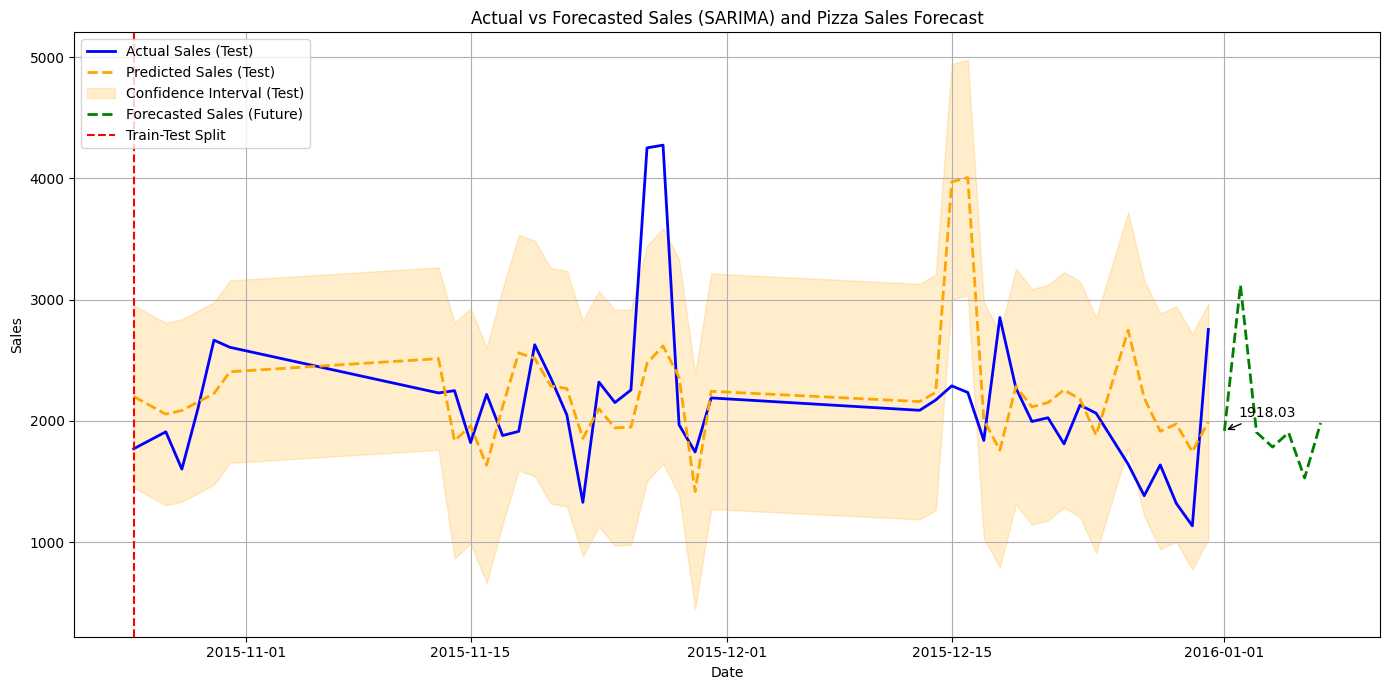

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
import pickle

def mape(actual, predicted):
    return np.mean(np.abs((actual - predicted) / (actual + 1e-10))) * 100

# Function to test for stationarity
def test_stationarity(series):
    result = adfuller(series)
    print(f"ADF Statistic: {result[0]}")
    print(f"p-value: {result[1]}")
    if result[1] < 0.05:
        print("Series is stationary (reject H0)")
    else:
        print("Series is non-stationary (fail to reject H0)")

print("Testing stationarity of original series:")
test_stationarity(daily_sales['daily_sales'])

train_size = int(len(daily_sales) * 0.8)
train, test = daily_sales[:train_size], daily_sales[train_size:]

# SARIMA: Seasonal ARIMA Model
best_score = float("inf")
best_order = None
best_model = None
tuning_results = [] 

# Try different combinations of p, d, q, P, D, Q (seasonal order)
for p, d, q, P, D, Q in itertools.product(range(0, 4), range(0, 2), range(0, 4), range(0, 2), range(0, 2), range(0, 4)):
    try:
        model = SARIMAX(train['daily_sales'], 
                        exog=train[['is_holiday', 'lag_1', 'lag_7']], 
                        order=(p, d, q), 
                        seasonal_order=(P, D, Q, 7), 
                        enforce_stationarity=False, enforce_invertibility=False)
        model_fit = model.fit(disp=False)
        predictions = model_fit.forecast(steps=len(test), exog=test[['is_holiday', 'lag_1', 'lag_7']])
        error = mape(test['daily_sales'], predictions)
        
        # Save hyperparameter tuning result
        tuning_results.append({
            'order': (p, d, q, P, D, Q),
            'mape': error
        })
        
        if error < best_score:
            best_score = error
            best_order = (p, d, q, P, D, Q)
            best_model = model_fit
    except Exception as e:
        print(f"SARIMAX({p}, {d}, {q}, {P}, {D}, {Q}) failed: {e}")
        continue

print(f"Best SARIMA Order: {best_order}")

sarima_best_model = best_model

sarima_tuning_results = pd.DataFrame(tuning_results)
test_predictions = sarima_best_model.forecast(steps=len(test), exog=test[['is_holiday', 'lag_1', 'lag_7']])
mae_value = mae(test['daily_sales'], test_predictions)
mse_value = mse(test['daily_sales'], test_predictions)
rmse_value = np.sqrt(mse_value)
mape_value = mape(test['daily_sales'], test_predictions)
print(f"\nEvaluation Metrics:")
print(f"MAE: {mae_value:.4f}")
print(f"RMSE: {rmse_value:.4f}")
print(f"MAPE: {mape_value:.4f}")

# Forecasting
forecast_steps = 7
forecast = sarima_best_model.forecast(steps=forecast_steps, exog=test[['is_holiday', 'lag_1', 'lag_7']].tail(forecast_steps))

forecast_dates = pd.date_range(start=daily_sales['order_date'].iloc[-1] + pd.Timedelta(days=1), periods=forecast_steps)
forecast_df = pd.DataFrame({'order_date': forecast_dates, 'forecasted_sales': forecast})

total_forecasted_sales_sarima = forecast_df['forecasted_sales'].sum()

print("Day-by-Day Forecasted Sales for the Next Week:")
print(forecast_df)
print(f"\nTotal Forecasted Sales for the Week: {total_forecasted_sales_sarima:.2f}")
plt.figure(figsize=(14, 7))
plt.plot(test['order_date'], test['daily_sales'], label='Actual Sales (Test)', color='blue', linestyle='-', linewidth=2)
plt.plot(test['order_date'], sarima_best_model.forecast(steps=len(test), exog=test[['is_holiday', 'lag_1', 'lag_7']]), label='Predicted Sales (Test)', color='orange', linestyle='--', linewidth=2)
conf_int = sarima_best_model.get_forecast(steps=len(test), exog=test[['is_holiday', 'lag_1', 'lag_7']]).conf_int()
plt.fill_between(test['order_date'], conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='orange', alpha=0.2, label='Confidence Interval (Test)')
plt.plot(forecast_df['order_date'], forecast_df['forecasted_sales'], label='Forecasted Sales (Future)', color='green', linestyle='--', linewidth=2)

plt.axvline(x=test['order_date'].iloc[0], color='red', linestyle='--', label='Train-Test Split')

plt.annotate(
    f"{forecast_df['forecasted_sales'].iloc[0]:.2f}",
    xy=(forecast_df['order_date'].iloc[0], forecast_df['forecasted_sales'].iloc[0]),
    xytext=(10, 10),
    textcoords='offset points',
    arrowprops=dict(arrowstyle='->', color='black'),
    fontsize=10
)

plt.title('Actual vs Forecasted Sales (SARIMA) and Pizza Sales Forecast')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend(loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()



Prophet (Developed by Facebook)

07:05:32 - cmdstanpy - INFO - Chain [1] start processing
07:05:33 - cmdstanpy - INFO - Chain [1] done processing


MAPE for Prophet: 17.7526
RMSE: 641.49
MAE: 438.15
Day-by-Day Forecasted Sales for the Next Week:
2016-01-01: 1892.05
2016-01-02: 2182.82
2016-01-03: 2374.12
2016-01-04: 2401.16
2016-01-05: 2495.08
2016-01-06: 2959.05
2016-01-07: 2495.99

Total Forecasted Sales for the Week: 16800.27


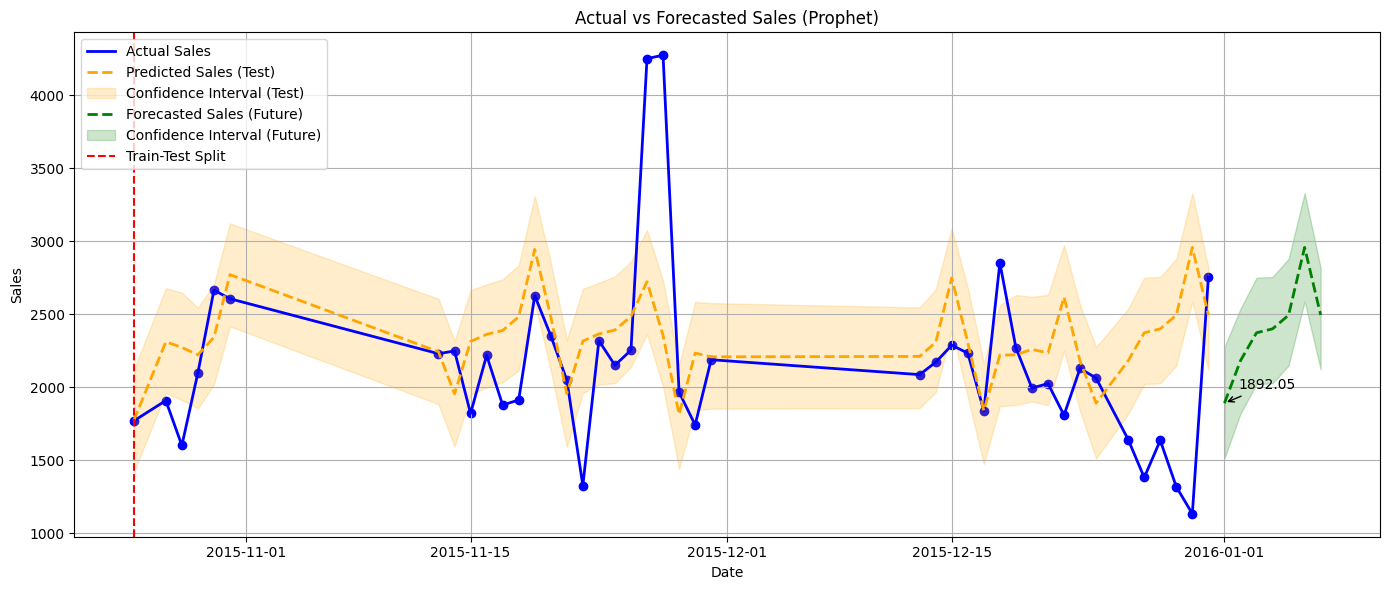

In [18]:
from prophet import Prophet
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

prophet_data = daily_sales[['order_date', 'daily_sales', 'is_holiday', 'lag_1', 'lag_7']].rename(columns={'order_date': 'ds', 'daily_sales': 'y'})
scaler = MinMaxScaler()
prophet_data[['is_holiday', 'lag_1', 'lag_7']] = scaler.fit_transform(prophet_data[['is_holiday', 'lag_1', 'lag_7']])

train_size = int(len(daily_sales) * 0.8)  
train_prophet = prophet_data[:train_size]
test_prophet = prophet_data[train_size:]

model_prophet = Prophet(
    changepoint_prior_scale=0.05,  
    seasonality_mode='multiplicative'  
)
model_prophet.add_seasonality(name='weekly', period=7, fourier_order=3)
model_prophet.add_regressor('is_holiday')
model_prophet.add_regressor('lag_1')
model_prophet.add_regressor('lag_7')

model_prophet.fit(train_prophet)

future = model_prophet.make_future_dataframe(periods=len(test_prophet), freq='D')
future = future.merge(prophet_data[['ds', 'is_holiday', 'lag_1', 'lag_7']], on='ds', how='left')
future.fillna(0, inplace=True)  
forecast = model_prophet.predict(future)
forecast_test = forecast[-len(test_prophet):]

#evaluation metrics
def mape(actual, predicted):
    return np.mean(np.abs((actual - predicted) / (actual + 1e-10))) * 100

from sklearn.metrics import mean_squared_error, mean_absolute_error
mape_value = mape(test_prophet['y'], forecast_test['yhat'])
rmse_value = np.sqrt(mean_squared_error(test_prophet['y'], forecast_test['yhat']))
mae_value = mean_absolute_error(test_prophet['y'], forecast_test['yhat'])

print(f"MAPE for Prophet: {mape_value:.4f}")
print(f"RMSE: {rmse_value:.2f}")
print(f"MAE: {mae_value:.2f}")
plt.figure(figsize=(14, 6))
plt.plot(test_prophet['ds'], test_prophet['y'], label='Actual Sales', color='blue', linestyle='-', linewidth=2)
plt.scatter(test_prophet['ds'], test_prophet['y'], color='blue', marker='o')  
plt.plot(test_prophet['ds'], forecast_test['yhat'], label='Predicted Sales (Test)', color='orange', linestyle='--', linewidth=2)
plt.fill_between(
    test_prophet['ds'],
    forecast_test['yhat_lower'],
    forecast_test['yhat_upper'],
    color='orange',
    alpha=0.2,
    label='Confidence Interval (Test)'
)

forecast_steps = 7  
forecast_future = forecast[-forecast_steps:]  
forecast_dates = pd.date_range(start=daily_sales['order_date'].iloc[-1] + pd.Timedelta(days=1), periods=forecast_steps)
forecast_df = pd.DataFrame({'order_date': forecast_dates, 'forecasted_sales': forecast_future['yhat'].values})
total_forecasted_sales = forecast_future['yhat'].sum()

print("Day-by-Day Forecasted Sales for the Next Week:")
for date, sales in zip(forecast_df['order_date'], forecast_df['forecasted_sales']):
    print(f"{date.strftime('%Y-%m-%d')}: {sales:.2f}")

print(f"\nTotal Forecasted Sales for the Week: {total_forecasted_sales:.2f}")
plt.plot(forecast_df['order_date'], forecast_df['forecasted_sales'], label='Forecasted Sales (Future)', color='green', linestyle='--', linewidth=2)
plt.fill_between(
    forecast_df['order_date'],
    forecast_future['yhat_lower'].values,
    forecast_future['yhat_upper'].values,
    color='green',
    alpha=0.2,
    label='Confidence Interval (Future)'
)

plt.axvline(x=test_prophet['ds'].iloc[0], color='red', linestyle='--', label='Train-Test Split')
plt.annotate(
    f"{forecast_df['forecasted_sales'].iloc[0]:.2f}",
    xy=(forecast_df['order_date'].iloc[0], forecast_df['forecasted_sales'].iloc[0]),
    xytext=(10, 10),
    textcoords='offset points',
    arrowprops=dict(arrowstyle='->', color='black'),
    fontsize=10
)

plt.title('Actual vs Forecasted Sales (Prophet)')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend(loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


Regression Model

MAPE for Linear Regression: 19.7733
RMSE: 610.86
MAE: 405.20

Day-by-Day Forecasted Sales for the Next Week:
2016-01-01: 2160.91
2016-01-02: 1961.03
2016-01-03: 2011.38
2016-01-04: 2132.95
2016-01-05: 2099.41
2016-01-06: 2112.63
2016-01-07: 2126.13

Total Forecasted Sales for the Week: 14604.44


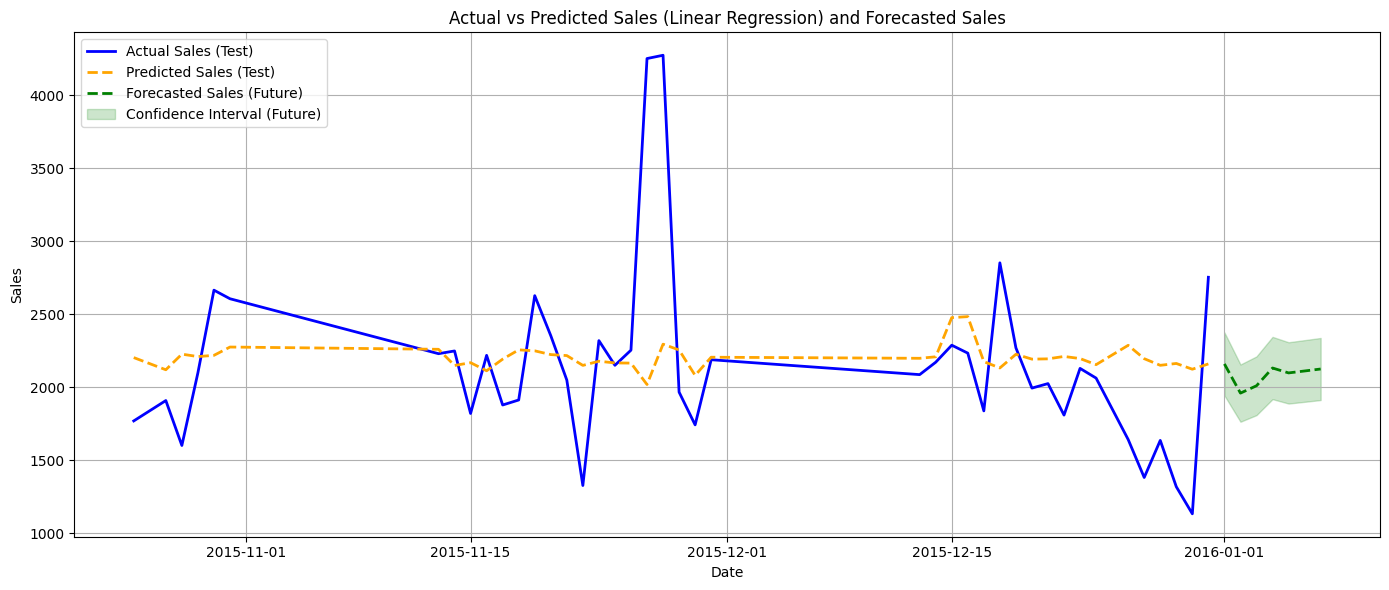

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler

lr_data = daily_sales[['order_date', 'daily_sales', 'is_holiday', 'lag_1', 'lag_7']].rename(columns={'order_date': 'ds', 'daily_sales': 'y'})
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(lr_data[['y', 'is_holiday', 'lag_1', 'lag_7']])
train_size = int(len(scaled_data) * 0.8)
train, test = scaled_data[:train_size], scaled_data[train_size:]

X_train = train[:, 1:]  
y_train = train[:, 0]   
X_test = test[:, 1:]
y_test = test[:, 0]


model = LinearRegression()
model.fit(X_train, y_train)
predictions = model.predict(X_test)
predictions_rescaled = scaler.inverse_transform(
    np.hstack((predictions.reshape(-1, 1), np.zeros((predictions.shape[0], scaled_data.shape[1] - 1))))
)[:, 0]
y_test_rescaled = scaler.inverse_transform(
    np.hstack((y_test.reshape(-1, 1), np.zeros((y_test.shape[0], scaled_data.shape[1] - 1))))
)[:, 0]

mape_value = np.mean(np.abs((y_test_rescaled - predictions_rescaled) / (y_test_rescaled + 1e-10))) * 100
rmse_value = np.sqrt(mean_squared_error(y_test_rescaled, predictions_rescaled))
mae_value = mean_absolute_error(y_test_rescaled, predictions_rescaled)

num_future_days = 7  
forecasted_sales = []


last_row = test[-1, 1:]  

for _ in range(num_future_days):
    
    next_prediction = model.predict(last_row.reshape(1, -1))[0]
    forecasted_sales.append(next_prediction)

    
    last_row = np.array([next_prediction] + last_row[:-1].tolist())  


forecasted_sales_rescaled = scaler.inverse_transform(
    np.hstack((np.array(forecasted_sales).reshape(-1, 1), np.zeros((len(forecasted_sales), scaled_data.shape[1] - 1))))
)[:, 0]


last_date = pd.to_datetime(lr_data['ds'].iloc[-1])
forecast_dates = [last_date + pd.Timedelta(days=i) for i in range(1, num_future_days + 1)]


confidence_interval_lower = forecasted_sales_rescaled * 0.9  
confidence_interval_upper = forecasted_sales_rescaled * 1.1  


total_forecasted_sales = sum(forecasted_sales_rescaled)


forecast_df = pd.DataFrame({
    'Date': forecast_dates,
    'Forecasted Sales': forecasted_sales_rescaled,
    'Lower Confidence Interval': confidence_interval_lower,
    'Upper Confidence Interval': confidence_interval_upper
})


print(f"MAPE for Linear Regression: {mape_value:.4f}")
print(f"RMSE: {rmse_value:.2f}")
print(f"MAE: {mae_value:.2f}")


print("\nDay-by-Day Forecasted Sales for the Next Week:")
for idx, row in forecast_df.iterrows():
    print(f"{row['Date'].date()}: {row['Forecasted Sales']:.2f}")


print(f"\nTotal Forecasted Sales for the Week: {total_forecasted_sales:.2f}")

plt.figure(figsize=(14, 6))
test_dates = lr_data['ds'].iloc[train_size:].reset_index(drop=True)
plt.plot(test_dates, y_test_rescaled, label='Actual Sales (Test)', color='blue', linestyle='-', linewidth=2)
plt.plot(test_dates, predictions_rescaled, label='Predicted Sales (Test)', color='orange', linestyle='--', linewidth=2)
plt.plot(forecast_dates, forecasted_sales_rescaled, label='Forecasted Sales (Future)', color='green', linestyle='--', linewidth=2)
plt.fill_between(forecast_dates, confidence_interval_lower, confidence_interval_upper, color='green', alpha=0.2, label='Confidence Interval (Future)')
plt.title('Actual vs Predicted Sales (Linear Regression) and Forecasted Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend(loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


Best model

Model Evaluation Metrics (MAPE):
        Model     MAPE
0       ARIMA  19.2229
1      SARIMA   3.6691
2     Prophet  17.7526
3  Regression  20.5615

Best Model Based on MAPE:
Model    SARIMA
MAPE     3.6691
Name: 1, dtype: object

The best model is: SARIMA


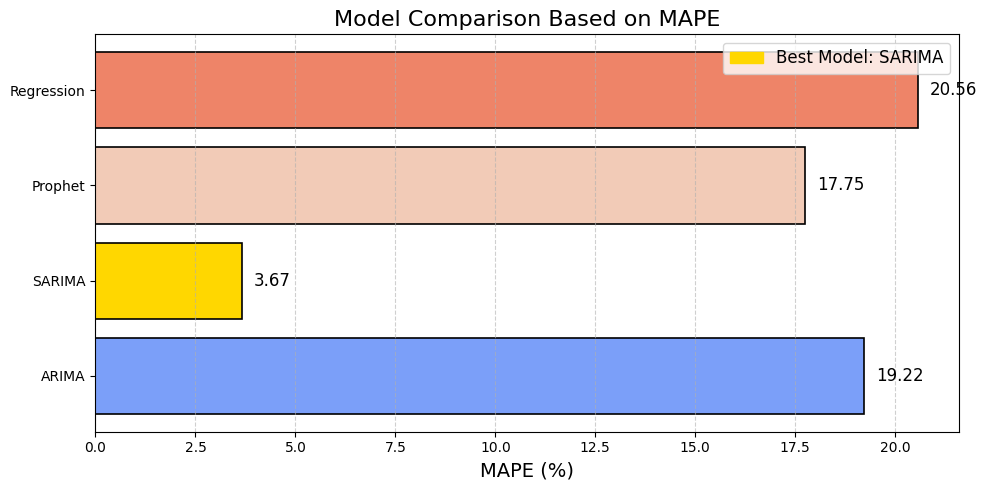

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

results = pd.DataFrame({
    'Model': ['ARIMA', 'SARIMA', 'Prophet', 'Regression'],
    'MAPE': [19.2229, 3.6691, 17.7526, 20.5615]
})

print("Model Evaluation Metrics (MAPE):")
print(results)
best_model = results.sort_values(by='MAPE').iloc[0]
print("\nBest Model Based on MAPE:")
print(best_model)
best_model_name = best_model['Model']
print(f"\nThe best model is: {best_model_name}")
plt.figure(figsize=(10, 5))
color_map = sns.color_palette("coolwarm", len(results))  
bars = plt.barh(results['Model'], results['MAPE'], color=color_map)
plt.xlabel('MAPE (%)', fontsize=14)
plt.title('Model Comparison Based on MAPE', fontsize=16)
plt.grid(axis='x', linestyle='--', alpha=0.6)

for index, value in enumerate(results['MAPE']):
    plt.text(value + 0.3, index, f'{value:.2f}', va='center', fontsize=12, color='black')


best_model_index = results[results['Model'] == best_model_name].index[0]  
bars[best_model_index].set_color('gold')  


plt.legend([bars[best_model_index]], ['Best Model: ' + best_model_name], loc='upper right', fontsize=12)


for bar in bars:
    bar.set_edgecolor('black')
    bar.set_linewidth(1.2)


plt.tight_layout()
plt.show()


In [22]:
print("\nSARIMA Model Summary:")
print(sarima_best_model.summary())



SARIMA Model Summary:
                                 SARIMAX Results                                 
Dep. Variable:               daily_sales   No. Observations:                  167
Model:             SARIMAX(0, 0, [1], 7)   Log Likelihood               -1174.904
Date:                   Wed, 18 Dec 2024   AIC                           2359.809
Time:                           07:05:48   BIC                           2375.153
Sample:                                0   HQIC                          2366.040
                                   - 167                                         
Covariance Type:                     opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
is_holiday  -106.2014    278.090     -0.382      0.703    -651.247     438.844
lag_1          0.1376      0.086      1.594      0.111      -0.032       0.307
lag_7

In [23]:
print("\nsarima_tuning_results Summary:")
print(sarima_tuning_results)


sarima_tuning_results Summary:
                  order       mape
0    (0, 0, 0, 0, 0, 0)  11.514078
1    (0, 0, 0, 0, 0, 1)   3.669115
2    (0, 0, 0, 0, 0, 2)   4.338691
3    (0, 0, 0, 0, 0, 3)   4.693432
4    (0, 0, 0, 0, 1, 0)  24.859767
..                  ...        ...
507  (3, 1, 3, 1, 0, 3)  21.820620
508  (3, 1, 3, 1, 1, 0)  23.332518
509  (3, 1, 3, 1, 1, 1)  14.716778
510  (3, 1, 3, 1, 1, 2)  23.932913
511  (3, 1, 3, 1, 1, 3)  22.459962

[512 rows x 2 columns]


In [24]:
import pickle

with open("best_sarima_model.pkl", "wb") as f:
    pickle.dump(best_model, f)
    print("\nsaved to 'best_sarima_model.pkl'.")



saved to 'best_sarima_model.pkl'.


In [25]:
import pickle


with open('best_sarima_model.pkl', 'wb') as file:
    pickle.dump(model, file)

In [26]:
pizza_ingredients.head(10)

,pizza_name_id,pizza_name,pizza_ingredients,Items_Qty_In_Grams
0,bbq_ckn_l,The Barbecue Chicken Pizza,Barbecued Chicken,40.0
1,bbq_ckn_l,The Barbecue Chicken Pizza,Red Peppers,15.0
2,bbq_ckn_l,The Barbecue Chicken Pizza,Green Peppers,20.0
3,bbq_ckn_l,The Barbecue Chicken Pizza,Tomatoes,30.0
4,bbq_ckn_l,The Barbecue Chicken Pizza,Red Onions,60.0
5,bbq_ckn_l,The Barbecue Chicken Pizza,Barbecue Sauce,15.0
6,bbq_ckn_m,The Barbecue Chicken Pizza,Barbecued Chicken,30.0
7,bbq_ckn_m,The Barbecue Chicken Pizza,Red Peppers,10.0
8,bbq_ckn_m,The Barbecue Chicken Pizza,Green Peppers,15.0
9,bbq_ckn_m,The Barbecue Chicken Pizza,Tomatoes,20.0


In [27]:
pizza_ingredients.isna().sum()

pizza_name_id         0
pizza_name            0
pizza_ingredients     0
Items_Qty_In_Grams    3
dtype: int64

In [28]:
total_forecasted_sales_sarima = 1000  
total_pizza_sales = pizza_ingredients['Items_Qty_In_Grams'].sum()
forecasted_sales_dict = {}
for _, row in pizza_ingredients.iterrows():
    pizza_sales_proportion = row['Items_Qty_In_Grams'] / total_pizza_sales
    forecasted_sales_dict[row['pizza_name_id']] = total_forecasted_sales_sarima * pizza_sales_proportion

ingredients_predicted = pizza_ingredients.copy()
ingredients_predicted['predicted_quantity'] = ingredients_predicted['pizza_name_id'].map(forecasted_sales_dict)
ingredients_predicted['total_ingredient_qty'] = ingredients_predicted['Items_Qty_In_Grams'] * ingredients_predicted['predicted_quantity']
ingredient_totals = ingredients_predicted.groupby('pizza_ingredients')['total_ingredient_qty'].sum().to_dict()
print("Total ingredient requirements based on forecasted sales:")
print(ingredient_totals)


Total ingredient requirements based on forecasted sales:
{'?duja Salami': 88.9453621346887, 'Alfredo Sauce': 46.060991105463785, 'Anchovies': 61.944091486658195, 'Artichokes': 412.96060991105463, 'Arugula': 44.47268106734435, 'Asiago Cheese': 196.95044472681067, 'Bacon': 2185.514612452351, 'Barbecue Sauce': 22.236340533672173, 'Barbecued Chicken': 63.53240152477763, 'Beef Chuck Roast': 2655.654383735705, 'Blue Cheese': 28.589580686149937, 'Brie Carre Cheese': 9.529860228716645, 'Calabrese Salami': 222.3634053367217, 'Capocollo': 889.4536213468868, 'Caramelized Onions': 9.529860228716645, 'Chicken': 2096.569250317662, 'Chipotle Sauce': 133.41804320203303, 'Chorizo Sausage': 158.83100381194407, 'Cilantro': 66.70902160101652, 'Coarse Sicilian Salami': 177.8907242693774, 'Corn': 447.90343074968234, 'Eggplant': 177.8907242693774, 'Feta Cheese': 1432.6556543837355, 'Fontina Cheese': 133.41804320203303, 'Friggitello Peppers': 22.236340533672173, 'Garlic': 852.9224904701398, 'Genoa Salami': 13

In [29]:
import pandas as pd
ingredient_totals_df = pd.DataFrame(list(ingredient_totals.items()), columns=['Ingredient', 'Total_Quantity in Grams'])
print(ingredient_totals_df)


                 Ingredient  Total_Quantity in Grams
0              ?duja Salami                88.945362
1             Alfredo Sauce                46.060991
2                 Anchovies                61.944091
3                Artichokes               412.960610
4                   Arugula                44.472681
..                      ...                      ...
59       Sun-dried Tomatoes               133.418043
60  Thai Sweet Chilli Sauce                88.945362
61                    Thyme                 1.588310
62                 Tomatoes              1785.260483
63                 Zucchini               133.418043

[64 rows x 2 columns]


In [30]:
total_pizza_sales = pizza_ingredients['Items_Qty_In_Grams'].sum()
print(f"Total pizza sales (sum of all ingredients in grams): {total_pizza_sales}")


Total pizza sales (sum of all ingredients in grams): 15740.0


In [31]:
print("Total ingredient quantity for some pizzas:")
print(ingredients_predicted[['pizza_name_id', 'predicted_quantity', 'total_ingredient_qty']].head(50))


Total ingredient quantity for some pizzas:
   pizza_name_id  predicted_quantity  total_ingredient_qty
0      bbq_ckn_l            0.952986             38.119441
1      bbq_ckn_l            0.952986             14.294790
2      bbq_ckn_l            0.952986             19.059720
3      bbq_ckn_l            0.952986             28.589581
4      bbq_ckn_l            0.952986             57.179161
5      bbq_ckn_l            0.952986             14.294790
6      bbq_ckn_m            0.635324             19.059720
7      bbq_ckn_m            0.635324              6.353240
8      bbq_ckn_m            0.635324              9.529860
9      bbq_ckn_m            0.635324             12.706480
10     bbq_ckn_m            0.635324             25.412961
11     bbq_ckn_m            0.635324              6.353240
12     bbq_ckn_s            0.317662              6.353240
13     bbq_ckn_s            0.317662              1.588310
14     bbq_ckn_s            0.317662              6.353240
15     bbq_ck

In [32]:
print("Top ingredients by total quantity required:")
print(sorted(ingredient_totals.items(), key=lambda x: x[1], reverse=True)[:10])


Top ingredients by total quantity required:
[('Red Onions', 3634.0533672172805), ('Beef Chuck Roast', 2655.654383735705), ('Bacon', 2185.514612452351), ('Chicken', 2096.569250317662), ('Tomatoes', 1785.2604828462515), ('Pepperoni', 1696.315120711563), ('Mushrooms', 1524.7776365946631), ('Feta Cheese', 1432.6556543837355), ('Spinach', 1095.9339263024142), ('Capocollo', 889.4536213468868)]


In [33]:
# Forecasting sales for the next 7 days
ingredients_predicted['weekly_forecasted_sales'] = ingredients_predicted['predicted_quantity'] * 7
print("Pizza-wise forecast for the next 7 days:")
print(ingredients_predicted[['pizza_name_id', 'predicted_quantity', 'weekly_forecasted_sales']].head())


Pizza-wise forecast for the next 7 days:
  pizza_name_id  predicted_quantity  weekly_forecasted_sales
0     bbq_ckn_l            0.952986                 6.670902
1     bbq_ckn_l            0.952986                 6.670902
2     bbq_ckn_l            0.952986                 6.670902
3     bbq_ckn_l            0.952986                 6.670902
4     bbq_ckn_l            0.952986                 6.670902


In [34]:
total_weekly_sales = ingredients_predicted['weekly_forecasted_sales'].sum()
print(f"Total forecasted sales for the week: {total_weekly_sales}")


Total forecasted sales for the week: 4816.391359593394


In [35]:
weekly_ingredient_totals = ingredients_predicted.groupby('pizza_ingredients')['total_ingredient_qty'].sum()
print("Weekly ingredient totals for the next 7 days:")
print(weekly_ingredient_totals)


Weekly ingredient totals for the next 7 days:
pizza_ingredients
?duja Salami                 88.945362
Alfredo Sauce                46.060991
Anchovies                    61.944091
Artichokes                  412.960610
Arugula                      44.472681
                              ...     
Sun-dried Tomatoes          133.418043
Thai Sweet Chilli Sauce      88.945362
Thyme                         1.588310
Tomatoes                   1785.260483
Zucchini                    133.418043
Name: total_ingredient_qty, Length: 64, dtype: float64
